In [12]:
import torch
from lavis.models import load_model_and_preprocess

C:\Users\usuario\Desktop\Photo_Categorization\photoCategorization\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\usuario\Desktop\Photo_Categorization\photoCategorization\venv\Lib\site-packages\fairscale\experimental\nn\offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
C:\Users\usuario\Desktop\Photo_Categorization\photoCategorization\venv\Lib\site-packages\fairscale\experimental\nn\offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore


### Carga del Modelo

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


In [14]:
print(str(device))
model, vis_processors, txt_processors = load_model_and_preprocess(name="pnp_vqa", model_type="base", is_eval=True, device=device)


cuda


C:\Users\usuario\Desktop\Photo_Categorization\photoCategorization\venv\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\usuario\Desktop\Photo_Categorization\photoCategorization\venv\Lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed

### Carga de las preguntas

In [15]:
image_path = "C:/Users/usuario/Desktop/Photo_Categorization/photoCategorization/data/modeling/Imagenes2018-2020/NECKERMANN_SUMMER_CHIPRE_OTROS_0019_035.jpg"

In [16]:
from PIL import Image
image = Image.open(image_path).convert('RGB')

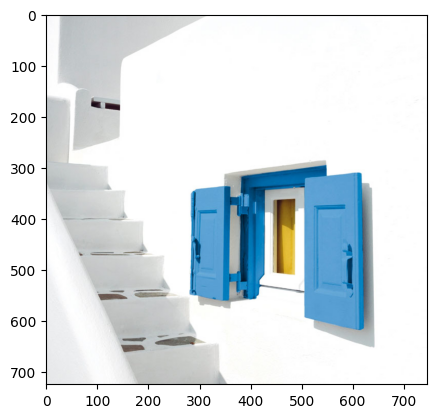

In [17]:
from matplotlib import pyplot as plt

plt.imshow(image)

In [18]:
from src.controllers.QuestionController import QuestionController
from src.config.config import CONFIG
from src.services.internal.DataProcessor import DataProcessor

question_controller = QuestionController(CONFIG['mongodb'])
subjects = question_controller.load_questions('Subject_categorization')
activities = question_controller.load_questions('Represented_activities_categorization')
context = question_controller.load_questions('Context_categorization')

In [19]:
data_processor = DataProcessor(CONFIG['data'], "pnp_testing")
prompts = data_processor.generate_prompts(subjects, activities, context)

In [105]:
print(prompts)

{'subject1': 'Question: Provide a numeric value between 0 and 5, 0 for none one in the image. How many people are visible in the image?? Answer:', 'subject2': 'Question: You must answer with one of these options: primary, secondary, or no people visible. Do the people in the image have a primary or secondary role?? Answer:', 'subject3': 'Question: You must answer with one of these options: male, female, both, or no people visible. What is the gender of the people visible in the image?? Answer:', 'subject4': 'Question: You must answer with one of these options: locals, workers, tourists, or no people visible. Are the people in the image locals, workers, or tourists?? Answer:', 'subject5': 'Question: Choose all that apply: children, young adults, adults, elderly, or no people visible. What age categories are present in the image?? Answer:', 'subject6': 'Question: You must answer with one of these options: family, couple, neither, or no people visible. Is it a family travel group, a coupl

In [121]:
image_tensor = vis_processors["eval"](image).unsqueeze(0).to(device)
question = txt_processors["eval"](prompts["context12"])

In [122]:
samples = {"image": image_tensor, "text_input": [question]}

In [123]:
pred_answers, caption, gradcam = model.predict_answers(samples, num_captions=50, num_patches=20)
print('Question: {} \nPredicted answer: {}'.format(question, pred_answers[0]))

Question: question you must answer with one of these options sports, shopping, other leisure activities, or none which type of leisure and recreation activity is most prominent?? answer 
Predicted answer: sports, shopping, other leisure activities


In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
token = os.getenv("HF_TOKEN")
repo_name = "Yorchz/mi-dataset-de-images"

### Carga del dataset

In [ ]:
from data_controler.HuggingFace_data_controler.HuggingFaceController import HuggingFaceController

huggingface_controller = HuggingFaceController()
huggingface_connection = huggingface_controller.build_connection(token)
dataset = huggingface_controller.build_loader(repo_name).load_images()

### Creamos el csv para guardar los datos

In [ ]:
import pandas as pd

headers = ['Imagen', 'Numero_personas', 'Relevancia', 'Sexo', 'Localidad', 'Edad', 'Tipo_grupo', 'Tipo_actividad', 'Actividad']

df = pd.DataFrame(columns=headers)
df.to_csv('pruebas/data1.csv', index=False)

In [ ]:
def add_rows(data):
    new_rows = pd.DataFrame(data, columns=headers)
    
    df = pd.read_csv('pruebas/data1.csv')
    df = pd.concat([df, new_rows], ignore_index=True)
    df.to_csv('pruebas/data1.csv', index=False)

### Realizamos pregutas y subida de las respuestas 

In [ ]:
prompts = [f"Question: {getattr(subject, f'question{i}')}? Answer:" for i in range(1, 7)] + \
          [f"Question: {getattr(activity, f'question{i}')}? Answer:" for i in range(1, 3)]
images = [item['image'] for item in dataset['train']]
labels = [item['label'] for item in dataset['train']]

In [ ]:
def model_generate(image_tensor, prompt, model):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    return model.generate({"image": image_tensor, "prompt": prompt})

In [ ]:
import torchvision.transforms as transforms
import pandas as pd

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajusta según las dimensiones esperadas por el modelo
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Ajusta según los requisitos del modelo
])

for i in range(len(images)):
    image = images[i]
    label = labels[i]
    
    # Transformar la imagen a tensor
    image_tensor = transform(image)
    print(f"Image nº{i+1} processed")
    
    # Generar respuestas para cada prompt
    row = [label]
    for prompt in prompts:
        answer = model_generate(image_tensor, prompt, model)
        row.append(answer)
    
    # Añadir la fila al CSV
    add_rows([row])

### Intentos individuales para afinar las preguntas una a una 

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajusta según las dimensiones esperadas por el modelo
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Ajusta según los requisitos del modelo
])

In [ ]:
print(subject.question1)

In [ ]:
print(model_generate(transform(images[9]), subject.question1, model))

In [ ]:
print(images[15])